## Import libraries

In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import collections
from collections import namedtuple
import builtins
import math

In [2]:
from resurfemg.config import Config
from resurfemg.tmsisdk_lite import Poly5Reader
import resurfemg.helper_functions as hf
import resurfemg.converter_functions as cf

## Reruns should be done from this cell as the start

In [3]:
config = Config()

root_emg_directory = config.get_directory('root_emg_directory')

In [4]:
name_emg = 'C:/Users/judit/OneDrive - UMCG/EMG - amplitude - devent/Data_poly5/Pt_8.Poly5'

In [5]:
data_emg = Poly5Reader(name_emg)
data_samples = data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds =  []
converted_to_samples = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)
    converted_to_samples.append(i)
data_samples = data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds =  []
converted_to_samples = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)
    converted_to_samples.append(i)

Reading file  C:/Users/judit/OneDrive - UMCG/EMG - amplitude - devent/Data_poly5/Pt_8.Poly5
	 Number of samples:  5596912 
	 Number of channels:  18 
	 Sample rate: 500 Hz
Done reading data.


In [6]:
data_samples.shape

(18, 5596912)

Text(0.5, 0.98, '18 kanalen 8RAW?')

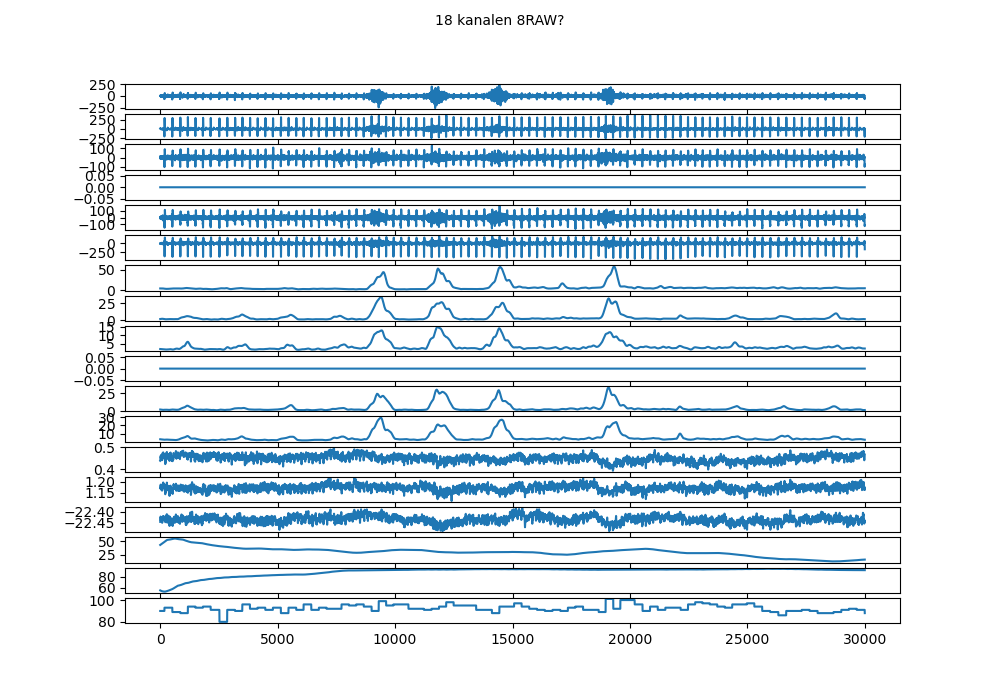

In [7]:
fig, axs = plt.subplots(18, 1, figsize=(10,7))
axs[0].plot(data_emg.samples[0][1:30000])
axs[1].plot(data_emg.samples[1][1:30000])
axs[2].plot(data_emg.samples[2][1:30000])
axs[3].plot(data_emg.samples[3][1:30000])
axs[4].plot(data_emg.samples[4][1:30000])
axs[5].plot(data_emg.samples[5][1:30000])
axs[6].plot(data_emg.samples[6][1:30000])
axs[7].plot(data_emg.samples[7][1:30000])
axs[8].plot(data_emg.samples[8][1:30000])
axs[9].plot(data_emg.samples[9][1:30000])
axs[10].plot(data_emg.samples[10][1:30000])
axs[11].plot(data_emg.samples[11][1:30000])
axs[12].plot(data_emg.samples[12][1:30000])
axs[13].plot(data_emg.samples[13][1:30000])
axs[14].plot(data_emg.samples[14][1:30000])
axs[15].plot(data_emg.samples[15][1:30000])
axs[16].plot(data_emg.samples[16][1:30000])
axs[17].plot(data_emg.samples[17][1:30000])
fig.suptitle('18 kanalen 8RAW?',fontsize=10)


Text(0.5, 1.0, 'Abdominal')

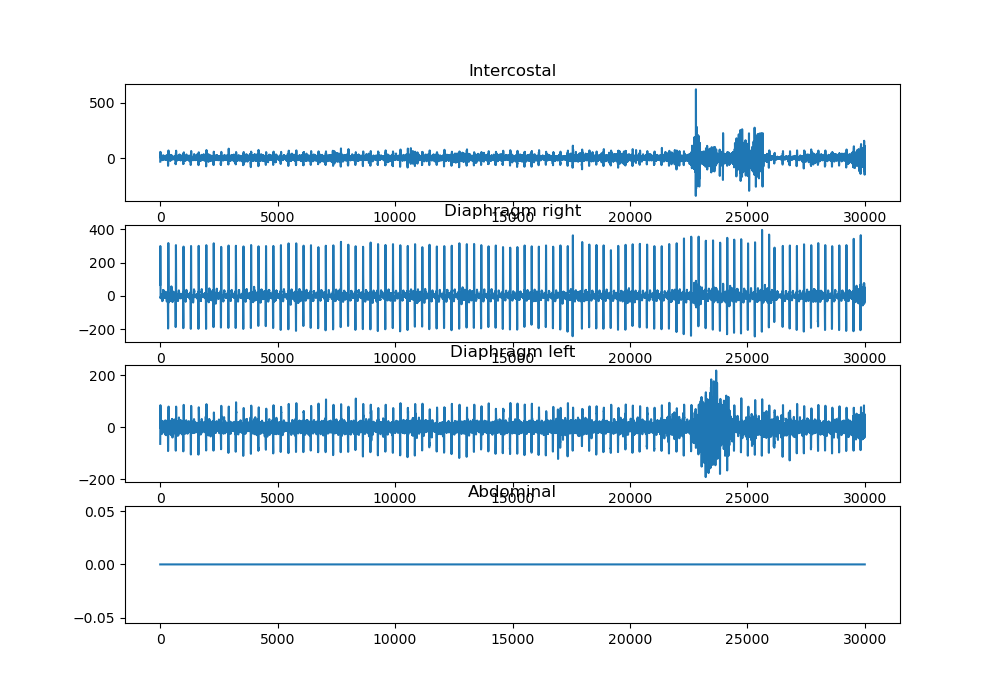

In [8]:
#plt.close(plt.gcf())
fig1, axs1 = plt.subplots(4, 1, figsize=(10,7))
axs1[0].plot(data_emg.samples[0][30000:60000])
axs1[0].set_title('Intercostal')
axs1[1].plot(data_emg.samples[1][30000:60000])
axs1[1].set_title('Diaphragm right')
axs1[2].plot(data_emg.samples[2][30000:60000])
axs1[2].set_title('Diaphragm left')
axs1[3].plot(data_emg.samples[3][30000:60000])
axs1[3].set_title('Abdominal')


In [9]:
dia_f=data_samples[1]

In [10]:
plt.close(plt.gcf())
plt.plot(dia_f[00000:30000])

## Filter EMG lead 'frontal diaphragm'

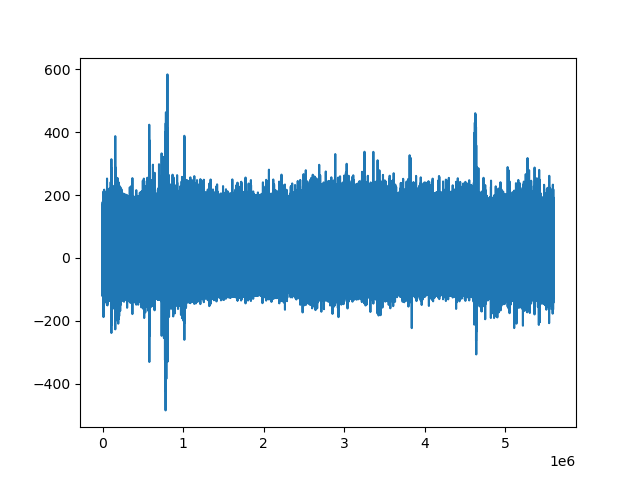

In [11]:
low_freq=20
high_freq=200
sample_rate=500
emg_data_filtered=hf.emg_bandpass_butter_sample(dia_f,low_freq,high_freq,sample_rate)
plt.figure()
plt.plot(emg_data_filtered)

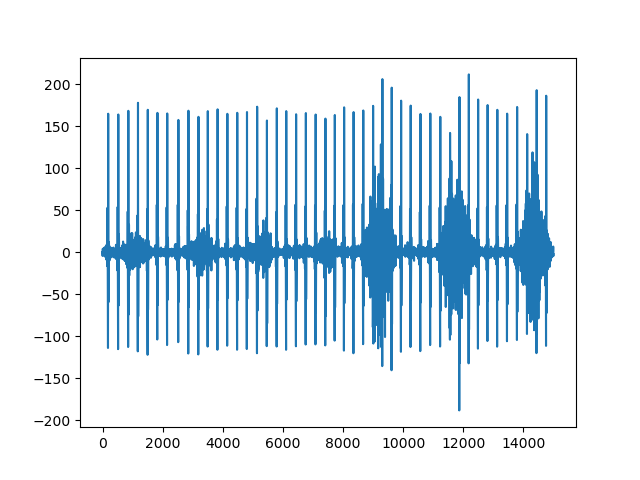

In [12]:
plt.close(plt.gcf())
plt.figure()
plt.plot(emg_data_filtered[0:15000])

# Notch filter 50 Hz

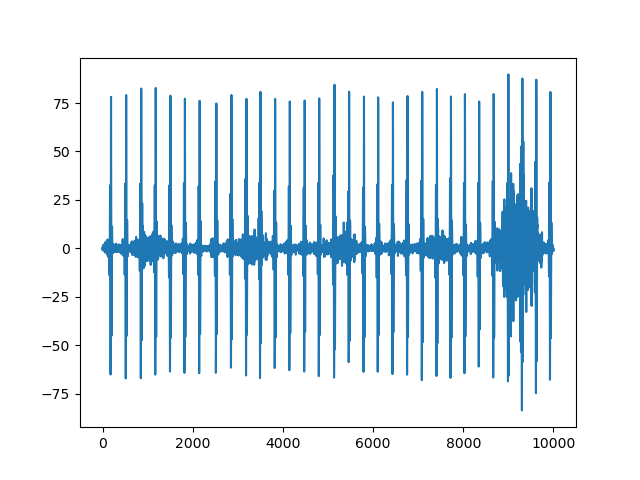

In [13]:
plt.close(plt.gcf())
emg_filt=hf.notch_filter(emg_data_filtered, 500, 50, 1)
plt.figure()
plt.plot(emg_filt[0:10000])


# Notch filter 20 Hz

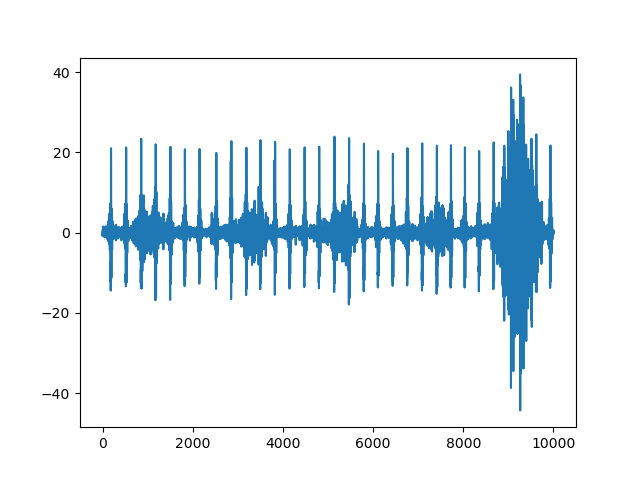

In [14]:
plt.close(plt.gcf())
emg_filt2=hf.notch_filter(emg_filt, 500, 20, 1)
plt.figure()
plt.plot(emg_filt2[0:10000])


# ECG removal

In [15]:
ecg_rms = hf.full_rolling_rms(emg_filt2, 10)
ecg_rms2=ecg_rms[0:10000]
peak_width = 0.01
peak_fraction = 0.40
peak_height = peak_fraction * (max(ecg_rms2) - min(ecg_rms2))
ecg_peaks, _ = find_peaks(ecg_rms, height=peak_height,width=peak_width * sample_rate, distance=int(sample_rate / 3))


In [16]:
gating_method=3
# 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 3: Moving average

gate_width = sample_rate//10
#ecg_rms = hf.full_rolling_rms(emg_filt, 10)
#peak_height = peak_fraction * (max(ecg_rms) - min(ecg_rms))
#ecg_peaks, _ = find_peaks(ecg_rms, height=peak_height,width=peak_width * sample_rate, distance=int(sample_rate / 3))

emg_clean = hf.gating(emg_filt2, ecg_peaks, gate_width, method=gating_method)
emg_clean = np.array(emg_clean)


In [17]:
np.shape(emg_clean)

(5596912,)

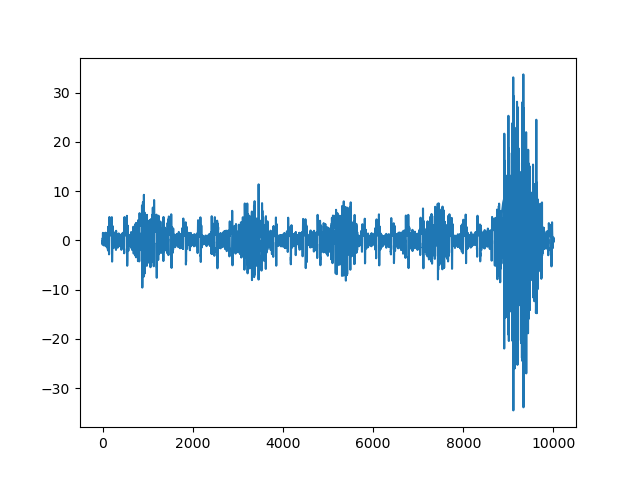

In [18]:
plt.close(plt.gcf())
fig, axs = plt.subplots(1)
axs.plot(emg_clean[0:10000])


# Root-mean square

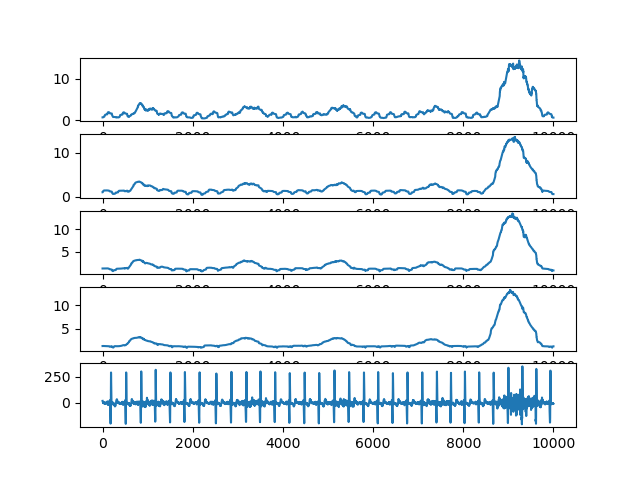

In [19]:
emg_rms0 = hf.full_rolling_rms(emg_clean,100)
emg_rms1 = hf.full_rolling_rms(emg_clean,200)
emg_rms2= hf.full_rolling_rms(emg_clean,250)
emg_rms3= hf.full_rolling_rms(emg_clean,300)
fig, axs = plt.subplots(5)

axs[0].plot(emg_rms0[0:10000])
axs[1].plot(emg_rms1[0:10000])
axs[2].plot(emg_rms2[0:10000])
axs[3].plot(emg_rms3[0:10000])
axs[4].plot(dia_f[0:10000])


Text(0.5, 0, 'Compare different windows')

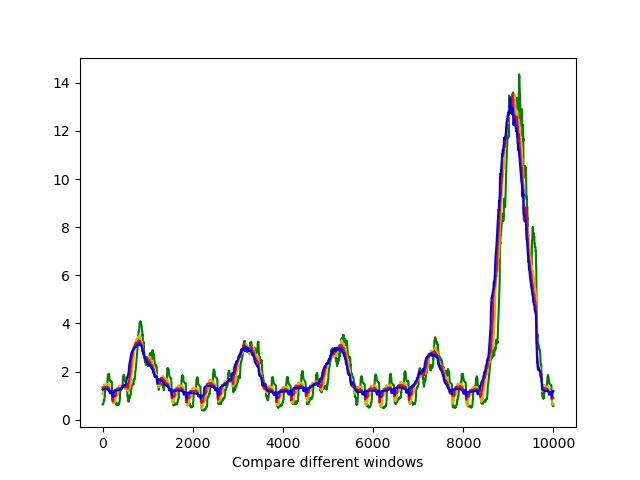

In [20]:
fig, axs = plt.subplots(1)
plt.plot(emg_rms0[0:10000], "g",emg_rms1[0:10000], "y", emg_rms2[0:10000], "r", emg_rms3[0:10000], "b")
plt.xlabel("Compare different windows")

Text(0.5, 0, 'Graph 1')

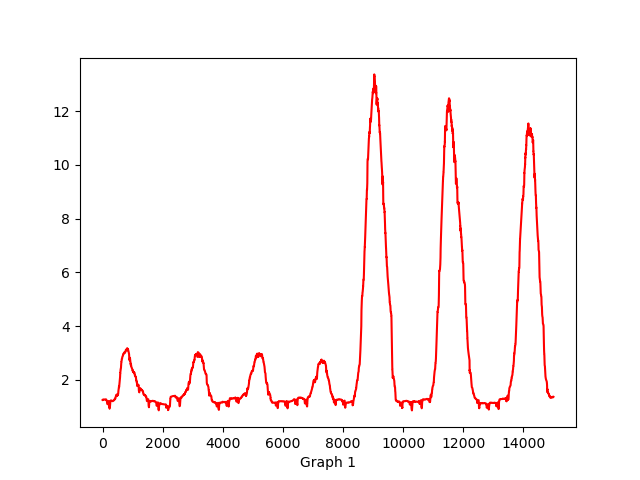

In [21]:
fig, axs = plt.subplots(1)
plt.plot(emg_rms3[00000:15000], "r")
plt.xlabel("Graph 1")

In [23]:
#Pick the right sample window; in this case of 300 samples = 0.6s
emg_rms=emg_rms3


In [24]:
emg_rms

array([1.2573588 , 1.26029982, 1.26480455, ..., 0.00309239, 0.00260525,
       0.00174674])

In [25]:
#closes all figures (if you get an error that too many figures are open)
plt.close('all')

In [26]:
#save filtered signal
new_file_name = 'C:/Users/judit/OneDrive - UMCG/EMG - amplitude - devent/Data_filtered/Pt_8_filtered.npy'
np.save(new_file_name, emg_rms)

# Finds peaks of RMS signal

In [27]:
peak_fraction=0.6 
peak_height = peak_fraction * (max(emg_rms[0:2000]) - min(emg_rms[0:2000]))
#peak_width = sample_rate/4
peak_distance = 3 * sample_rate

t_peaks, emg_peaks = find_peaks(emg_rms,height=peak_height,distance=peak_distance)


In [28]:
peak_height

1.3872623426631676

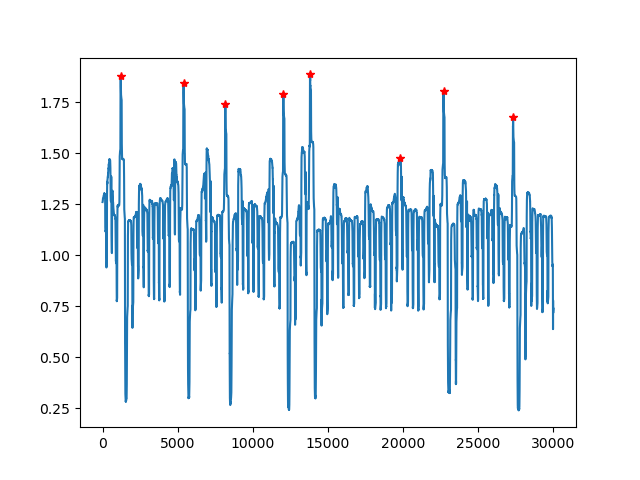

In [32]:
#plot only a part of the signal with its RMS peaks 
min_value = 1200000 #make a plot between sample min_value and max_value
max_value = 1230000

t_peaks_plot=[]
for value in t_peaks:
    if min_value <= value <= max_value:
        t_peaks_plot.append(value)

t_peaks_plot_x=[]       
for element in t_peaks_plot:
    t_peaks_plot_x.append(element - min_value)

plt.close(plt.gcf())
fig,axs=plt.subplots(1)
axs.plot(emg_rms[min_value:max_value])
axs.plot(t_peaks_plot_x ,emg_rms[t_peaks_plot], 'r*')

In [33]:
t_peaks

array([    821,    3169,    5209, ..., 5592334, 5594227, 5595839],
      dtype=int64)

In [34]:
emg_peaks

{'peak_heights': array([3.18196041, 3.03367555, 2.99947523, ..., 7.55174301, 5.08443504,
        6.9344518 ])}

In [35]:
#save peaks
new_file_name = 'C:/Users/judit/OneDrive - UMCG/EMG - amplitude - devent/Data_filtered/Pt_8_t_peaks.npy'
np.save(new_file_name, t_peaks)

#new_file_name = 'C:/Users/judit/OneDrive - UMCG/EMG - amplitude - devent/Data_filtered/Pt_8_peaks.npy'
#np.save(new_file_name, emg_peaks)
